In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
from RediCell_cupy import *
from DesignTool import *

Sides are [128  64  64] with spacing of 1.6e-08 m (3 dimensions).
Overall system sizes are [2.048e-06 1.024e-06 1.024e-06] m
Voxel [63 31 31] has a coordinate of [ 0.00000000e+00 -1.05879118e-22 -1.05879118e-22]
Voxel [100, 31, 31] has a coordinate of [ 5.92000000e-07 -1.05879118e-22 -1.05879118e-22]
Voxel [26, 31, 31] has a coordinate of [-5.92000000e-07 -1.05879118e-22 -1.05879118e-22]
Determined factor for a separating boundary as 0.7
Determined factor for a separating boundary as 0.7
Determined factor for a separating boundary as 0.7
Successfully created a E. coli rod


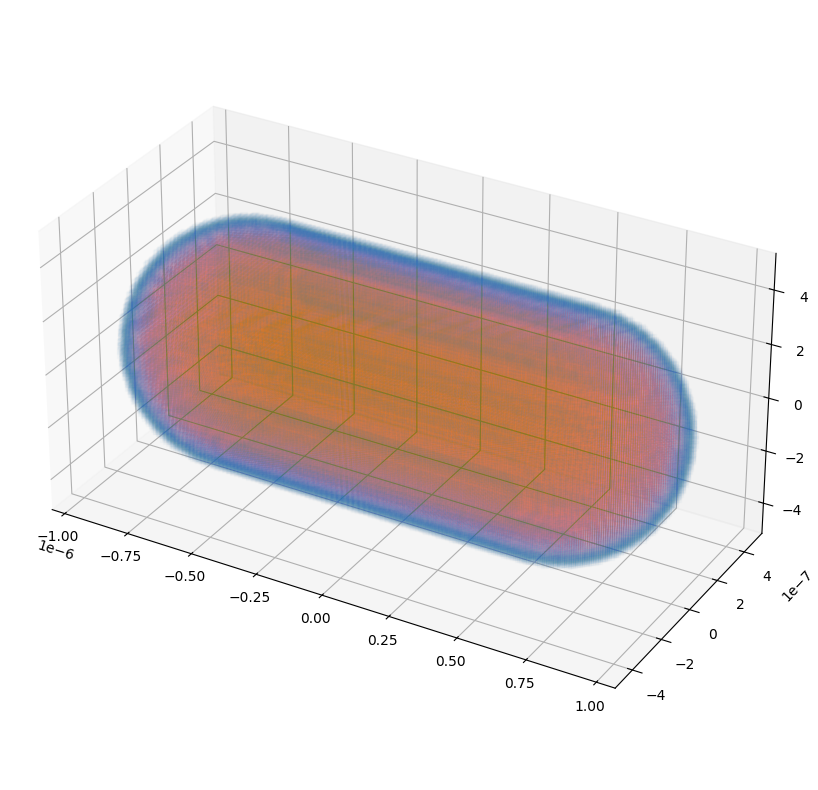

In [94]:
d = DesignTool()
d.get_blanket_space([131, 57, 57], spacing=16e-9, wall=False)
d.add_ecoli_rod(l=2e-6, r=0.4e-6, barrier_type=1, space_type=1, offsety=0, thickness=2, method='const')#, offsety=1.6e-7)
# d.set_border_wall()
%matplotlib inline
d.draw3D(exclude_barrier_type=[0], exclude_space_type=[0])


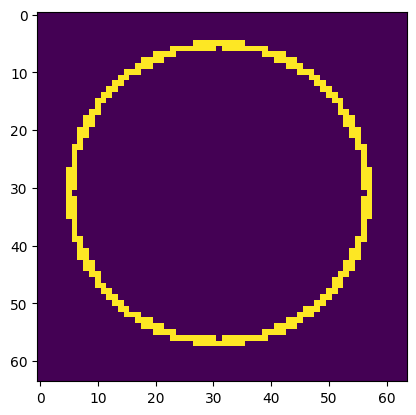

In [95]:
plt.imshow(d.barrier_type[65])

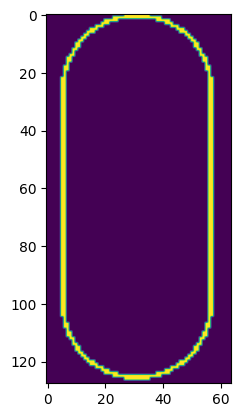

In [96]:
plt.imshow(d.barrier_type[:, 30])

In [97]:
mol_Iex = Molecule('Iex', diffusion_coefficient=1.28e-12, observed_barrier_types=None)
mol_Iin = Molecule('Iin', diffusion_coefficient=1.28e-12, observed_barrier_types=None)
mol_Y = Molecule('Y', diffusion_coefficient=0, observed_barrier_types=1)
mol_YI = Molecule('YI', diffusion_coefficient=0, observed_barrier_types=None)
# mol_B = Molecule('B', diffusion_coefficient=8.15e-14, observed_barrier_types=[1, 2])
# mol_C = Molecule('C', diffusion_coefficient=8.15e-14, observed_barrier_types=[1, 2])
# molset = MoleculeSet([mol_A, mol_B, mol_C])
molset = MoleculeSet([mol_Iex, mol_Iin, mol_Y, mol_YI])

In [98]:
rxset = ReactionSet()
rxset.add_reaction(['Iex'], ['Iin'], 2.33e-3)
rxset.add_reaction(['Iin'], ['Iex'], 2.33e-3)
rxset.add_reaction(['Y', 'Iex'], ['YI'], 3.03e+4)
rxset.add_reaction(['YI'], ['Y', 'Iex'], 1.2e-1)
rxset.add_reaction(['YI'], ['Y', 'Iin'], 1.2e+1)
# rxset.add_reaction(['A', 'B'], ['C'], 1.07e5)
# rxset.add_reaction(['C'], ['A', 'B'], 0.351)

In [99]:
a = RediCell_CuPy(design=d, molecule_types=molset, reaction_set=rxset, t_step=2e-3)

In [100]:
a_supply_matrix = cp.zeros(a.true_sides)
a_supply_matrix[(a.special_space_type == 0) * (a.barrier_type == -1)] = 1
a_supply_matrix[1:-1, 1:-1, [1, 2, -3, -2]] = 1
a_supply_matrix[1:-1, [1, 2, -3, -2], 1:-1] = 1
a_supply_matrix[[1, 2, -3, -2], 1:-1, 1:-1] = 1

a.add_external_conditions(a_supply_matrix, mol_Iex, 5)
a.show_external_conditions()

Maintain 5 micromolar of Iex within a space of 284377 voxels (3508 molecules)


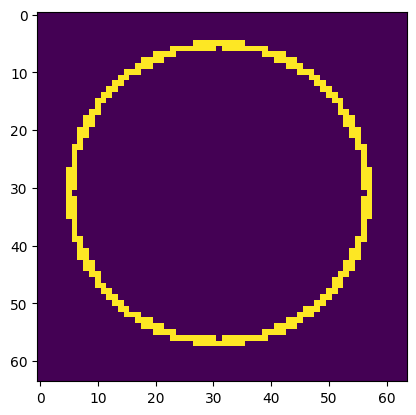

In [101]:
plt.imshow(a.barrier_type[80].get())

In [102]:
a.partition()

Reagent list: [[0], [1], [2, 0], [3], [3]]
Action list:
Diffusion of Iex (6 directions)
Diffusion of Iin (6 directions)
Diffusion of Y (6 directions)
Diffusion of YI (6 directions)
Reaction: reagent ['Iex'] -> product ['Iin']
Reaction: reagent ['Iin'] -> product ['Iex']
Reaction: reagent ['Y', 'Iex'] -> product ['YI']
Reaction: reagent ['YI'] -> product ['Y', 'Iex']
Reaction: reagent ['YI'] -> product ['Y', 'Iin']


In [103]:
a.configure_barrier()

In [104]:
a.maintain_external_conditions()

In [105]:
a.mesh[0].shape

(128, 64, 64)

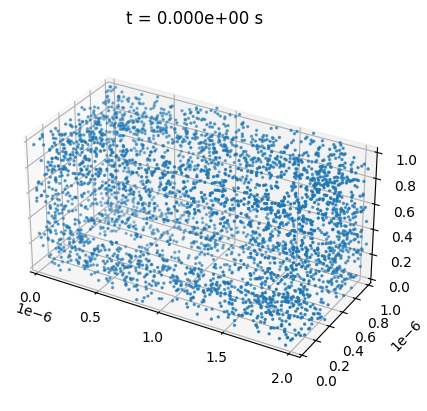

In [106]:
a.plot3D(['Iex'], wall=False)

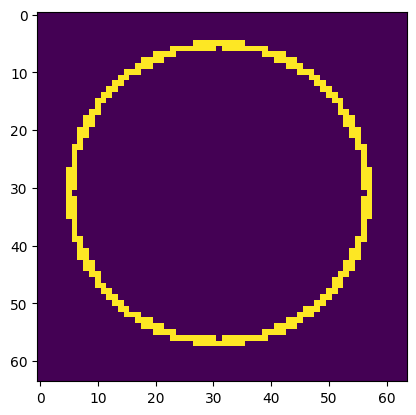

In [107]:
plt.imshow(a.barrier_type[50].get())

In [108]:

# inner = np.where(a.special_space_type == 1)
# num_voxel_inner = len(inner[0])
# print(num_voxel_inner)
# # Change half of that space
# choice = np.random.choice(num_voxel_inner, num_voxel_inner//2, replace=False)
# selection = [x[choice] for x in inner]
# a.barrier_type[selection[0], selection[1], selection[2]] = 2

# place 10000 B
# remaining_inner = np.where((a.special_space_type == 1) * (a.barrier_type == -1))
# num_voxel_remaining_inner = len(remaining_inner[0])
# print(num_voxel_remaining_inner)
# choice = np.random.choice(num_voxel_remaining_inner, 10000, replace=False)
# selection = [x[choice] for x in remaining_inner]
# a.voxel_matrix[1, selection[0], selection[1], selection[2]] = 1

In [109]:
# place 1000 Y where E coli barrier is
barriers = np.where(a.barrier_type.get() == 1)
num_voxel = len(barriers[0])
print(num_voxel)
choice = np.random.choice(num_voxel, 1000, replace=False)
selection = [x[choice] for x in barriers]
a.voxel_matrix[a.mol_to_id['Y'], selection[0], selection[1], selection[2]] = 1

30637


In [110]:
a.not_barrier_matrix_up.shape

(4, 127, 64, 64)

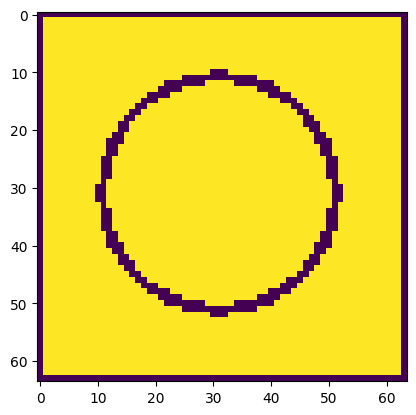

In [111]:
plt.imshow(a.not_barrier_matrix_up[2, 10].get())

In [112]:
a.voxel_matrix[0].sum()

array(3488., dtype=float16)

In [113]:
a.diffusion_vector

[29999.999999999996, 29999.999999999996, 0.0, 0.0]

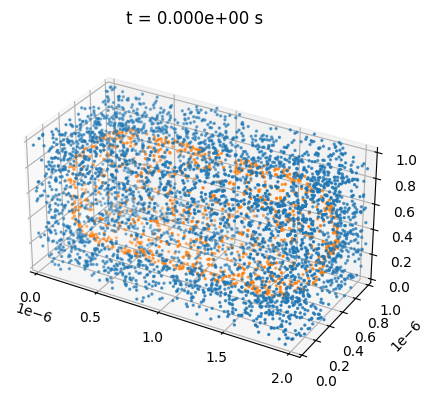

In [114]:
a.plot(['Iex', 'Y'], wall=False)

In [115]:
a.determine_maximum_timestep()

Max time step is 5.00e-05 s (max 1.0 particles in voxel)


array(5.e-05, dtype=float16)

In [116]:
a.simulate(30000, t_step=5e-3, plot_every=None, timing=False, checkpoint_every=None, traj_every=None)
a.plot(['Iex', 'Iin'], wall=False)

  0%|          | 53/30000 [00:00<00:57, 524.81it/s]

Simulate 30000 steps


 12%|█▏        | 3594/30000 [00:06<00:49, 531.68it/s]


KeyboardInterrupt: 

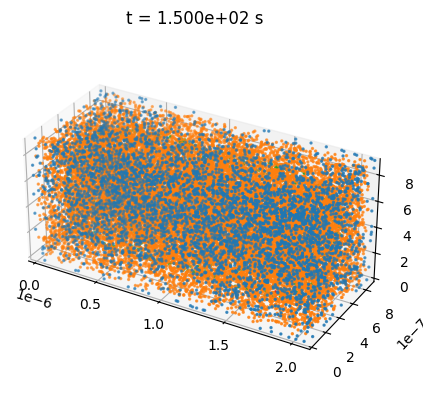

In [42]:
a.plot(['Iex','Iin', 'Y', 'YI'], wall=False)

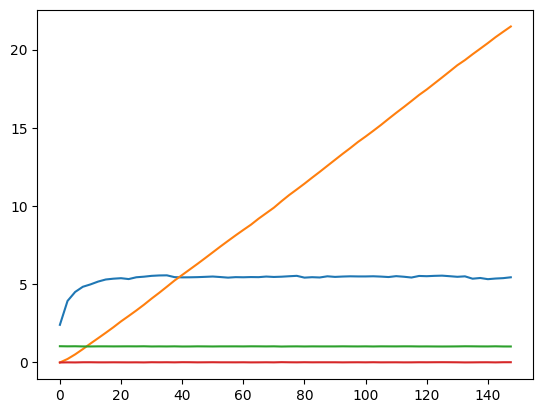

In [43]:
plt.plot(a.t_trace, np.array([x.astype(cp.float32).get() for x in a.conc_trace]) * a.one_per_voxel_equal_um / np.prod(np.array(a.voxel_matrix[0].shape) - 2))
# plt.yticks(range(7))
# plt.yscale('log')

In [44]:
a.voxel_matrix[1].astype(cp.float32).get().sum()

21040.0

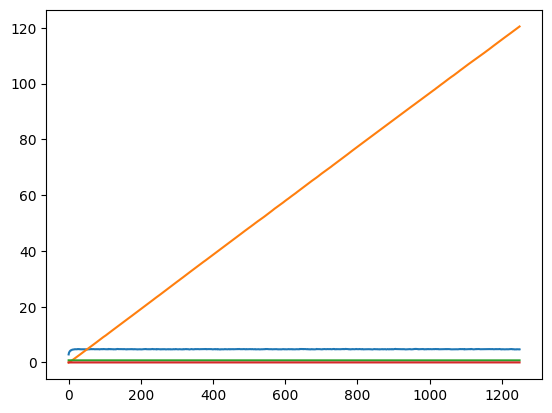

In [33]:
plt.plot(b.t_trace, np.array([x.astype(cp.float32).get() for x in b.conc_trace]) * b.one_per_voxel_equal_um / np.prod(np.array(b.voxel_matrix[0].shape) - 2))
# plt.yticks(range(7))
# plt.yscale('log')

In [36]:
a.one_per_voxel_equal_um

405.3472106923459

In [23]:
a.one_per_voxel_equal_um * float(a.voxel_matrix[a.mol_to_id['Iex']].sum()) / np.prod(np.array(a.voxel_matrix[0].shape) - 2)

5.059418004552291

In [26]:
np.prod(np.array(a.voxel_matrix[0].shape) - 2)

524288